<h4>Imports</h4>

In [22]:
#NOTE: autoreload is not recursive, only direct imports are reloaded
%load_ext autoreload
%autoreload 2
from data_translator import TestTranslator, EncodeForGA, GAToScheduleTranslator
from hybrid_solution_data_loader import get_data
from models import Order, SimulationEnvironment
from solver import GASolver, PSOSolver
from visualize import visualize_schedule_demo
import objective_function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h4>Read from Source</h4>

In [12]:
n_workstations, recipes, operation_times = get_data(0)
recipies, workstations, resources, tasks, _ = TestTranslator().translate(n_workstations, recipes, operation_times)

env = SimulationEnvironment(workstations, tasks, resources, recipies)

<h4>Create Orders</h4>

In [13]:
earliest_slot = 0
last_slot = 100
recipe_orders = [0, 1, 2, 3, 0, 3, 2, 1, 0, 3] # for dataset 0
orders = []
o_id = 0
for order in recipe_orders:
    orders.append(Order(o_id, 0, last_slot, last_slot, [order], 100, 50, False, 0, False, 500)) # for now: use resources to select recipe
    o_id = o_id + 1


<h4>Translate for Solver</h4>

In [14]:
# translate datamodel to encoding
encoder = EncodeForGA()
# TODO: alternatives can be completely removed (TEST first)
values, durations, all_jobs, alternatives = encoder.translate(env, orders) # encoding, duration lookup table, list of all jobs used (probably not needed), possible alternatives for each job


<h4>Run Solver</h4>

GA

In [29]:
# create solver object
crossover = 'two_points' #NOTE: available in PyGAD: 'two_points', 'single_point', 'uniform', 'scattered'
selection = 'rws' #NOTE: available in PyGAD: 'sss' (steady state selection', 'rws' (roulette wheel), 'sus' (stocastic universal selection), 'rank' (rank selection), 'random' (random selection), 'tournament' (tournament selection)
population_size = 50
offspring_amount = 100
max_generations = 2000

solver = GASolver(values, durations, all_jobs, alternatives, env, orders)
solver.initialize(earliest_slot, last_slot, population_size, offspring_amount, max_generations, crossover=crossover, selection=selection)
solver.run()

Done


PSO (don't run, currently under construction)

In [45]:
solver = PSOSolver(values, durations, all_jobs, env, orders)

solver.initialize(earliest_slot, last_slot, max_iter=1000)
solver.run()
print(solver.get_best())

Stopping search: maximum iterations reached --> 1000
However, the optimization couldn't find a feasible design. Sorry
[2, 35, 4, 14, 2, 18, 2, 22, 4, 35, 3, 96, 2, 3, 1, 78, 2, 9, 1, 68, 2, 49, 0, 9, 0, 37, 3, 0, 1, 34, 4, 92, 1, 34, 3, 42, 3, 5, 1, 60, 3, 80, 2, 26, 3, 30, 3, 72, 4, 4, 2, 82, 1, 99, 4, 76, 3, 60]


<h4>Result Output</h4>

In [30]:
result = solver.get_best()
#selected_tasks = solver.get_result_jobs() # selected task alternatives
fitness = solver.get_best_fitness()
print("Parameters of the best solution : {solution}".format(solution=result))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=abs(fitness)))
fitness_history = solver.assignments_best
average_fitness_history = solver.average_assignments


Parameters of the best solution : [ 3  0  4  1  1  6  0  0  0  2  0  7  2  0  2  6  0 11  2 13  0 13  3 14
  4  6  3 15  1 22  1 11  1 16  3  1  2 15  1 17  2 22  4  8  4 16  0 21
  2  8  2 17  4 22  0 14  0 15]
Fitness value of the best solution = 27


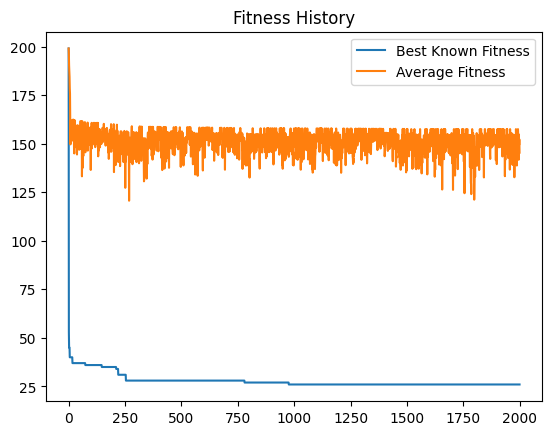

In [31]:
import matplotlib.pyplot as plt
if not len(fitness_history) == 0 and not len(average_fitness_history) == 0:
    x = list(range(0, len(fitness_history)))
    plt.plot(x, fitness_history)
    plt.plot(x, average_fitness_history)
    plt.title('Fitness History')
    plt.legend(['Best Known Fitness', 'Average Fitness'])
    plt.xlabel = 'Generation'
    plt.ylabel = 'Fitness'
    plt.show()

<h4>(Optional) Postprocessing</h4>

<h4>Translate to Schedule</h4>

In [32]:
schedule = GAToScheduleTranslator().translate(result, selected_tasks, env, orders)

<h4>Visualize Schedule</h4>

In [33]:
visualize_schedule_demo(schedule, env, orders)

<h4>Evaluate Schedule</h4>

In [34]:
#NOTE: the objective functions in this case assume the solution is feasible, no additional checks
#NOTE: currently the only objective function used during optimization is makespan
makespan, tardiness, deviation, idle_time, profit = objective_function.calculate_comparison_values(schedule, orders, env)
print(f'Fitness Values:\nMakespan: {makespan}\nTardiness: {tardiness}\nDeviation: {deviation}\nIdle Time: {idle_time}\nProfit: {profit}')

Fitness Values:
Makespan: 27
Tardiness: 0
Deviation: 808
Idle Time: 16
Profit: 5000
